In [197]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import geo

In [198]:
data = pd.read_csv('data_bc.csv')
dataBC = data[data['addressRegion'] == 'BC']
dataBC = dataBC.sort_values(by='addressLocality')
dataBC.head()

/var/folders/53/4sggflvx4kb3nlf4w_2td2z40000gn/T/ipykernel_28992/191140646.py:1: DtypeWarning: Columns (42,93,259) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data_bc.csv')


,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,description,price,priceCurrency,property-beds,...,MLS Area Minor,View,Foundation Details,SqFt Range,Building Area Source,Buyer Agent Designation,Lot Measurement,Lot Size Source,Topography,Current Financing
4337,"6263 MULLIGAN DRIVE, 100 Mile House, BC V0K2E3",100 Mile House,BC,V0K2E3,51.584053,-121.143606,* PREC - Personal Real Estate Corporation. WA...,647000.0,CAD,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4739,"6470 MERCER ROAD, 100 Mile House, BC V0K2E3",100 Mile House,BC,V0K2E3,51.611912,-121.236554,This tidy 2 bed / 2 bath manufactured home is ...,425000.0,CAD,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3148,"6847 FAWN LK AC01 ROAD, 100 Mile House, BC V0K1X1",100 Mile House,BC,V0K1X1,51.554452,-120.981004,When only the best will do!! Ultimate log home...,1100000.0,CAD,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
618,"825 SCOTT ROAD, 100 Mile House, BC V0K2E0",100 Mile House,BC,V0K2E0,51.634147,-121.301281,* PREC - Personal Real Estate Corporation. Me...,559000.0,CAD,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2216,"4741 TELQUA DRIVE, 100 Mile House, BC V0K2Z0",100 Mile House,BC,V0K2Z0,51.747026,-121.347015,* PREC - Personal Real Estate Corporation. No...,399900.0,CAD,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
dataBC = dataBC.filter([
    'streetAddress',
    'addressLocality',
    'addressRegion',
    'postalCode',
    'latitude',
    'longitude',
    'price',
    'property-beds',
    'property-baths',
    'property-sqft',
    'Garage',
    'Property Type', #Agricultural, Condo, Condo/Townhouse, Duplex, Manufactured Home, Mobile Home, MultiFamily, Single Family, Townhome, Vacant Land
    'Square Footage',
    ])
# data_bc_single_family = dataBC[dataBC['Property Type'] == 'Single Family']
property_types = ['Single Family','Condo', 'Townhome', 'MultiFamily']
data_bc_single_family = dataBC[dataBC['Property Type'].isin(property_types)]

In [200]:
metro_vancouver_cities = [
    "Vancouver", "Burnaby", "Richmond", "Surrey", "Coquitlam",
    "North Vancouver", "West Vancouver", "New Westminster",
    "Delta", "Port Coquitlam", "Port Moody", "Langley"
]
data_bc_single_family = data_bc_single_family[data_bc_single_family['addressLocality'].isin(metro_vancouver_cities)]
sample = data_bc_single_family.head()
sample

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage
7409,"51 N SEA AVENUE, Burnaby, BC V5B 1K4",Burnaby,BC,V5B 1K4,49.284733,-122.979824,2188000.0,5.0,3.0,"2,515",NaN,Single Family,"2,515 SQFT"
7383,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,1250000.0,3.0,3.0,"1,790",NaN,Townhome,"1,790 SQFT"
7376,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,978000.0,3.0,2.0,950,NaN,Condo,950 SQFT
12098,"7815 ALLMAN STREET, Burnaby, BC V5E 2A9",Burnaby,BC,V5E 2A9,49.235055,-122.950665,3999000.0,8.0,9.0,"6,399",NaN,Single Family,"6,399 SQFT"
12104,"1003 6383 MCKAY AVENUE, Burnaby, BC V5H 0H8",Burnaby,BC,V5H 0H8,49.226336,-123.006607,668000.0,1.0,1.0,533,NaN,Condo,533 SQFT


In [201]:
# data_bc_single_family.sort_values(by='Price', ascending=False)
# data_bc_single_family.to_csv('data_bc_1.csv')

In [202]:
lat_lon_array = sample[['latitude', 'longitude']].to_numpy()
lat_lon_array

array([[  49.2847328, -122.9798237],
       [  49.2322488, -122.9212089],
       [  49.2496906, -122.8940859],
       [  49.2350546, -122.950665 ],
       [  49.2263362, -123.0066066]])

In [203]:
# write code here for using geo.haversine() to get individual address distances

results = []
for lat, lon in lat_lon_array:
    amenities = geo.get_specific_amenities(lat, lon, radius=3000)
    conv_distance = []
    transit_distance = []
    school_distance = []

    if amenities:
        for a in amenities:
            dist = geo.haversine(lat, lon, a['latitude'], a['longitude'])
            if a.get('shop') in ['convencince', 'grocery']:
                conv_distance.append(dist)
            elif a.get('amenity') in ['bus_station', 'subway_station', 'railway_station']:
                transit_distance.append(dist)
            elif a.get('amenity') in ['school', 'university']:
                school_distance.append(dist)
            
    results.append({
        'latitude': lat,
        'longitude': lon,
        'avg_convenience_dist': np.mean(conv_distance),
        'avg_transit_distance': np.mean(transit_distance),
        'avg_school_distance': np.mean(school_distance)
    })

results_df = pd.DataFrame(results)
results_df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,latitude,longitude,avg_convenience_dist,avg_transit_distance,avg_school_distance
0,49.284733,-122.979824,NaN,NaN,2.351229
1,49.232249,-122.921209,NaN,2.485465,NaN
2,49.249691,-122.894086,NaN,1.020296,NaN
3,49.235055,-122.950665,2.691901,NaN,2.436122
4,49.226336,-123.006607,1.946606,NaN,1.542220


In [204]:
sample = sample.merge(
    results_df,
    how='left',
    on=['latitude', 'longitude']
)

In [205]:
sample

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance
0,"51 N SEA AVENUE, Burnaby, BC V5B 1K4",Burnaby,BC,V5B 1K4,49.284733,-122.979824,2188000.0,5.0,3.0,"2,515",NaN,Single Family,"2,515 SQFT",NaN,NaN,2.351229
1,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,1250000.0,3.0,3.0,"1,790",NaN,Townhome,"1,790 SQFT",NaN,2.485465,NaN
2,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,978000.0,3.0,2.0,950,NaN,Condo,950 SQFT,NaN,1.020296,NaN
3,"7815 ALLMAN STREET, Burnaby, BC V5E 2A9",Burnaby,BC,V5E 2A9,49.235055,-122.950665,3999000.0,8.0,9.0,"6,399",NaN,Single Family,"6,399 SQFT",2.691901,NaN,2.436122
4,"1003 6383 MCKAY AVENUE, Burnaby, BC V5H 0H8",Burnaby,BC,V5H 0H8,49.226336,-123.006607,668000.0,1.0,1.0,533,NaN,Condo,533 SQFT,1.946606,NaN,1.542220


In [206]:
print(sample['price'])

0    2188000.0
1    1250000.0
2     978000.0
3    3999000.0
4     668000.0
Name: price, dtype: float64


In [207]:
censusdata = pd.read_csv('CensusProfile2021.csv', encoding='latin1')
filtered_df = censusdata[censusdata.iloc[:, 0].str.contains("Income of individuals in", case=False, na=False)]
final_df = filtered_df[filtered_df.iloc[:, 1].str.contains("average|median", case=False, na=False)]
final_2020_df = final_df[
    final_df.iloc[:, 0].str.contains("2020", na=False) |
    final_df.iloc[:, 1].str.contains("2020", na=False)
]
final_2020_df = final_2020_df[final_2020_df.iloc[:, 1].str.contains("Median employment income in 2020 for full-year full-time workers in 2020", case=False, na=False)] 
# print(final_2020_df)
#final_2020_df.to_csv('CensusData_cleaned')
final_2020_df['Unnamed: 2'] = pd.to_numeric(final_2020_df['Unnamed: 2'], errors='coerce')
median_income = final_2020_df['Unnamed: 2'].iloc[0]

In [208]:

sample['Price-to-income Ratio'] = sample['price'] / median_income 
sample

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance,Price-to-income Ratio
0,"51 N SEA AVENUE, Burnaby, BC V5B 1K4",Burnaby,BC,V5B 1K4,49.284733,-122.979824,2188000.0,5.0,3.0,"2,515",NaN,Single Family,"2,515 SQFT",NaN,NaN,2.351229,33.661538
1,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,1250000.0,3.0,3.0,"1,790",NaN,Townhome,"1,790 SQFT",NaN,2.485465,NaN,19.230769
2,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,978000.0,3.0,2.0,950,NaN,Condo,950 SQFT,NaN,1.020296,NaN,15.046154
3,"7815 ALLMAN STREET, Burnaby, BC V5E 2A9",Burnaby,BC,V5E 2A9,49.235055,-122.950665,3999000.0,8.0,9.0,"6,399",NaN,Single Family,"6,399 SQFT",2.691901,NaN,2.436122,61.523077
4,"1003 6383 MCKAY AVENUE, Burnaby, BC V5H 0H8",Burnaby,BC,V5H 0H8,49.226336,-123.006607,668000.0,1.0,1.0,533,NaN,Condo,533 SQFT,1.946606,NaN,1.542220,10.276923


The code below is for normalizing data once we have it all cleaned up. We can ignore it for now and come back to it once we have clean data with all our columns

In [215]:
print(sample['Garage'].dtype)

float64


In [209]:
# features = ['Price', 'Bedrooms', 'Bathrooms', 'Acreage', 'Square Footage']
features = [
            'price',
            'property-beds', 
            'property-baths', 
            'property-sqft', 
            'Property Type', 
            'avg_convenience_dist', 
            'avg_transit_distance', 
            'avg_school_distance', 
            'Price-to-income Ratio',
        ]
scaler = MinMaxScaler()
# print(sample['property-sqft'].dtype)
sample['property-sqft'] = (sample['property-sqft'].str.replace(',', '', regex=False).astype(float))
sample['property-sqft'] = pd.to_numeric(sample['property-sqft'], errors='coerce')
sample['Property Type'] = sample['Property Type'].map({'Condo': 0.25, 'Townhome': 0.5, 'Single Family': 0.75, 'MultiFamily': 1})

convenience_max = sample['avg_convenience_dist'].max()
transit_max = sample['avg_transit_distance'].max()
school_max = sample['avg_school_distance'].max()
sample['avg_convenience_dist'] = sample['avg_convenience_dist'].fillna(convenience_max * 1.1)
sample['avg_transit_distance'] = sample['avg_transit_distance'].fillna(transit_max * 1.1)
sample['avg_school_distance'] = sample['avg_school_distance'].fillna(school_max * 1.1)
sample['Garage'] = sample['Garage'].map({'Yes': 1, 'NaN': 0})


In [210]:
data_scaled = sample.copy()
data_scaled["price"] = 1 - data_scaled['price']
data_scaled['avg_convenience_dist'] = 1 - data_scaled['avg_convenience_dist']
data_scaled['avg_transit_distance'] = 1 - data_scaled['avg_transit_distance']
data_scaled['avg_school_distance'] = 1 - data_scaled['avg_school_distance']
# data_scaled['Parking'] = data_scaled['Parking'].map({'Yes': 1, 'No': 0})
data_scaled[features] = scaler.fit_transform(sample[features])
data_scaled.head()

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance,Price-to-income Ratio
0,"51 N SEA AVENUE, Burnaby, BC V5B 1K4",Burnaby,BC,V5B 1K4,49.284733,-122.979824,0.456319,0.571429,0.250,0.337879,NaN,1.0,"2,515 SQFT",1.000000,1.000000,0.711208,0.456319
1,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,0.174722,0.285714,0.250,0.214286,NaN,0.5,"1,790 SQFT",1.000000,0.854966,1.000000,0.174722
2,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,0.093065,0.285714,0.125,0.071088,NaN,0.0,950 SQFT,1.000000,0.000000,1.000000,0.093065
3,"7815 ALLMAN STREET, Burnaby, BC V5E 2A9",Burnaby,BC,V5E 2A9,49.235055,-122.950665,1.000000,1.000000,1.000,1.000000,NaN,1.0,"6,399 SQFT",0.734653,1.000000,0.785838,1.000000
4,"1003 6383 MCKAY AVENUE, Burnaby, BC V5H 0H8",Burnaby,BC,V5H 0H8,49.226336,-123.006607,0.000000,0.000000,0.000,0.000000,NaN,0.0,533 SQFT,0.000000,1.000000,0.000000,0.000000


In [211]:
score_features = [
            'price',
            'property-beds', 
            'property-baths', 
            'property-sqft', 
            'Property Type', 
            'avg_convenience_dist', 
            'avg_transit_distance', 
            'avg_school_distance', 
            'Price-to-income Ratio',
        ]

weights = np.array([1/len(score_features)] * len(score_features))
# print(weights)
data_scored = data_scaled.copy()
data_scored['Score'] = data_scaled[score_features].dot(weights)
# data_scored.sort_values(by='Score', ascending=False, inplace=True)
data_scored

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance,Price-to-income Ratio,Score
0,"51 N SEA AVENUE, Burnaby, BC V5B 1K4",Burnaby,BC,V5B 1K4,49.284733,-122.979824,0.456319,0.571429,0.250,0.337879,NaN,1.0,"2,515 SQFT",1.000000,1.000000,0.711208,0.456319,0.642573
1,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,0.174722,0.285714,0.250,0.214286,NaN,0.5,"1,790 SQFT",1.000000,0.854966,1.000000,0.174722,0.494935
2,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,0.093065,0.285714,0.125,0.071088,NaN,0.0,950 SQFT,1.000000,0.000000,1.000000,0.093065,0.296437
3,"7815 ALLMAN STREET, Burnaby, BC V5E 2A9",Burnaby,BC,V5E 2A9,49.235055,-122.950665,1.000000,1.000000,1.000,1.000000,NaN,1.0,"6,399 SQFT",0.734653,1.000000,0.785838,1.000000,0.946721
4,"1003 6383 MCKAY AVENUE, Burnaby, BC V5H 0H8",Burnaby,BC,V5H 0H8,49.226336,-123.006607,0.000000,0.000000,0.000,0.000000,NaN,0.0,533 SQFT,0.000000,1.000000,0.000000,0.000000,0.111111


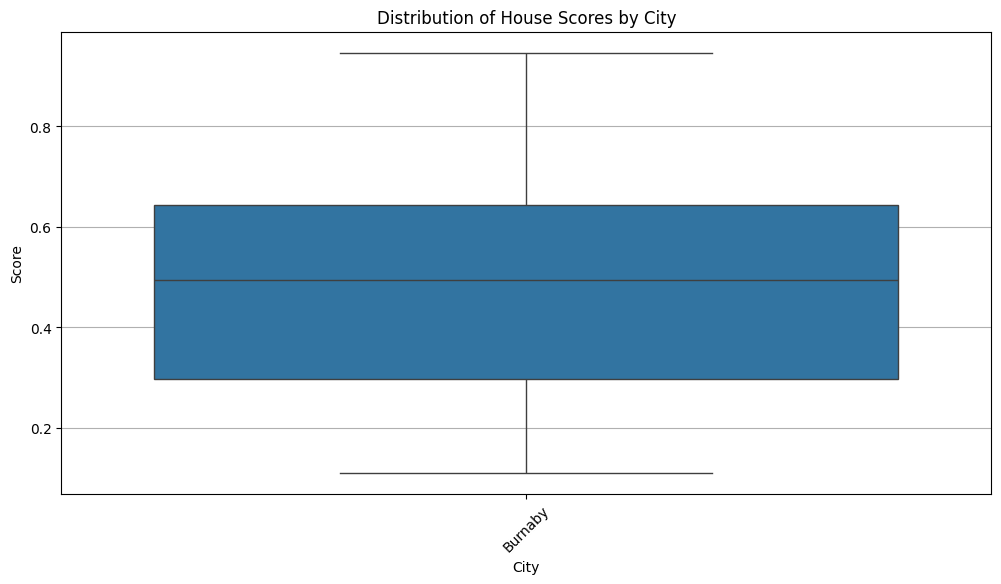

In [212]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='addressLocality', y='Score', data=data_scored)

plt.title('Distribution of House Scores by City')
plt.xlabel('City')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()